In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
!pip install sincnet_tensorflow

In [43]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, LeakyReLU, BatchNormalization, Flatten, MaxPooling1D, Input
from sincnet_tensorflow import SincConv1D, LayerNorm
from sklearn.model_selection import train_test_split

In [44]:
# Función para cargar datos
def cargar_datos(ruta_datos_enfermos, ruta_datos_sanos):
    # Cargar datos de personas enfermas
    datos_enfermos = []
    etiquetas_enfermos = []
    for archivo in os.listdir(ruta_datos_enfermos):
        if archivo.endswith(".wav"):
            archivo_path = os.path.join(ruta_datos_enfermos, archivo)
            datos_audio = cargar_audio(archivo_path)
            datos_enfermos.append(datos_audio)
            etiquetas_enfermos.append(1)  # Etiqueta 1 para personas enfermas

    # Cargar datos de personas sanas
    datos_sanos = []
    etiquetas_sanos = []
    for archivo in os.listdir(ruta_datos_sanos):
        if archivo.endswith(".wav"):
            archivo_path = os.path.join(ruta_datos_sanos, archivo)
            datos_audio = cargar_audio(archivo_path)
            datos_sanos.append(datos_audio)
            etiquetas_sanos.append(0)  # Etiqueta 0 para personas sanas

    X = np.concatenate([datos_enfermos, datos_sanos], axis=0)
    y = np.concatenate([etiquetas_enfermos, etiquetas_sanos], axis=0)

    return X, y

In [46]:
# Rutas de las carpetas con datos de audio
ruta_enfermos = "/content/drive/MyDrive/PROYECTO_FINAL/Frases_enfermos_HM_duplicado/export"
ruta_sanos = "/content/drive/MyDrive/PROYECTO_FINAL/frases sanos + whitenoise sanos"

# Cargar datos
X, y = cargar_datos(ruta_enfermos, ruta_sanos)

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
import os

def contar_audios_en_directorio(directorio):
    contador = 0
    extensiones_de_audio = ['.wav', '.mp3', '.ogg', '.flac']  # Agrega más extensiones si es necesario

    for raiz, directorios, archivos in os.walk(directorio):
        for archivo in archivos:
            if any(archivo.endswith(extension) for extension in extensiones_de_audio):
                contador += 1

    return contador

# Directorio donde se encuentran los archivos de audio
directorio_dataset_enfermos = '/content/drive/MyDrive/PROYECTO_FINAL/Frases_enfermos_HM_duplicado/export'
directorio_dataset_sanos='/content/drive/MyDrive/PROYECTO_FINAL/frases sanos + whitenoise sanos'

# Contar archivos de audio en el directorio
cantidad_audios = contar_audios_en_directorio(directorio_dataset_enfermos)
print("Cantidad de archivos de audio en el dataset_enfermos:", cantidad_audios)
cantidad_audios_sanos = contar_audios_en_directorio(directorio_dataset_sanos)
print("Cantidad de archivos de audio en el dataset_sanos:", cantidad_audios_sanos)


Cantidad de archivos de audio en el dataset_enfermos: 1724
Cantidad de archivos de audio en el dataset_sanos: 1656


In [51]:
#DEMOSTRACION DE AUDIO ORIGINAL
from scipy.io import wavfile
AudioName = "/content/drive/MyDrive/PROYECTO_FINAL/Frases_enfermos_HM_duplicado/export/1040-phrase.wav" # Archivo de Audio

# Salida fs: Frecuencia de muestreo and data: Señal de audio -> int16
fs, Audiodata = wavfile.read(AudioName)
print(f'Duracion = {Audiodata.shape[0]/fs} , Frecuencia de Muestreo = {fs} [=] Muestras/Seg' \
      f', Wav format = {Audiodata.dtype}')

Duracion = 2.28794 , Frecuencia de Muestreo = 50000 [=] Muestras/Seg, Wav format = int16


In [52]:
#dEMOSTRACION DE AUDIO CON RUIDO BLANCO

from scipy.io import wavfile
AudioName = "/content/drive/MyDrive/PROYECTO_FINAL/Frases_enfermos_HM_duplicado/export/aumentado1_1040-phrase.wav" # Archivo de Audio

# Salida fs: Frecuencia de muestreo and data: Señal de audio -> int16
fs, Audiodata_noise = wavfile.read(AudioName)
print(f'Duracion = {Audiodata_noise.shape[0]/fs} , Frecuencia de Muestreo = {fs} [=] Muestras/Seg' \
      f', Wav format = {Audiodata_noise.dtype}')

Duracion = 2.28794 , Frecuencia de Muestreo = 50000 [=] Muestras/Seg, Wav format = int16


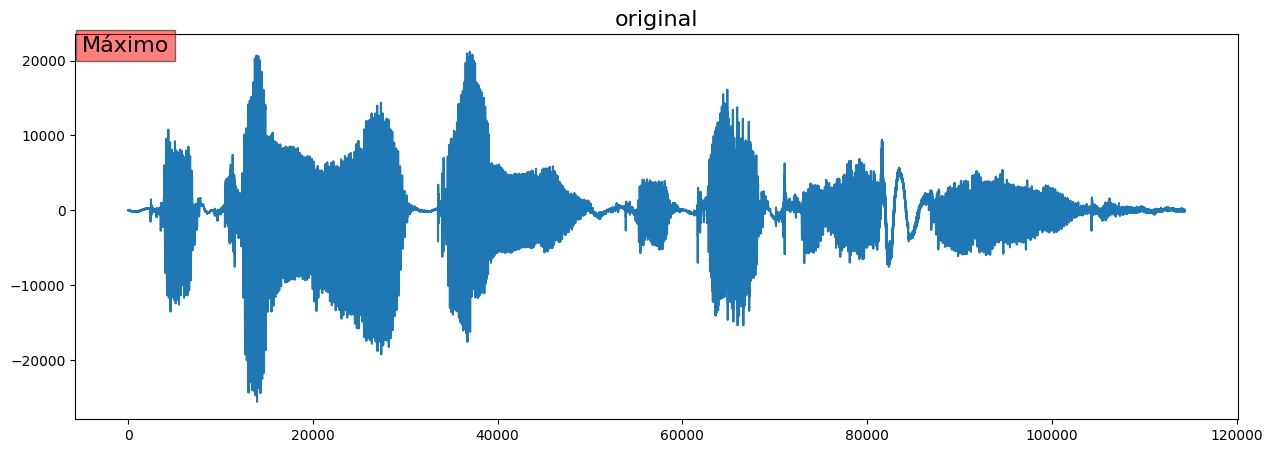

In [53]:
#GRAFICAR AUDIO ORIGINAL
import matplotlib.pyplot as plt #Libreria para realizar graficos

plt.rcParams['figure.figsize'] = (15, 5) # Definir el tamaño de graficas
plt.plot(Audiodata) # Audiodata es un numpy array
plt.text(0-5000, np.max(Audiodata), 'Máximo', fontsize = 16,bbox=dict(facecolor='red', alpha=0.5))
plt.title('original',size=16);


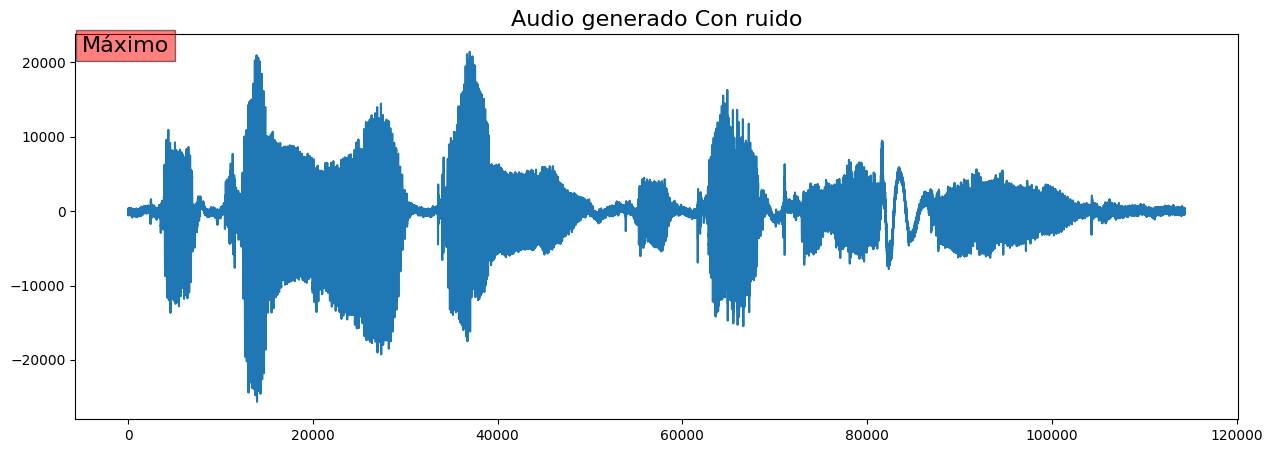

In [54]:
#GRAFICAR AUDIO GENERADO CON RUIDO BLANCO
plt.rcParams['figure.figsize'] = (15, 5) # Definir el tamaño de graficas
plt.plot(Audiodata_noise) # Audiodata es un numpy array
plt.text(0-5000, np.max(Audiodata_noise), 'Máximo', fontsize = 16,bbox=dict(facecolor='red', alpha=0.5))
plt.title('Audio generado Con ruido',size=16);


In [48]:
# Definir la arquitectura del modelo
out_dim = 50  # número de clases

sinc_layer = SincConv1D(N_filt=64, Filt_dim=129, fs=16000, stride=16, padding="SAME")

inputs = Input((31800, 1))
x = sinc_layer(inputs)
x = LayerNorm()(x)

x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling1D(pool_size=2)(x)

# Resto de las capas...

# Definición del modelo
x = Flatten()(x)
x = Dense(256)(x)
x = BatchNormalization(momentum=0.05, epsilon=1e-5)(x)
x = LeakyReLU(alpha=0.2)(x)

x = Dense(256)(x)
x = BatchNormalization(momentum=0.05, epsilon=1e-5)(x)
x = LeakyReLU(alpha=0.2)(x)


In [49]:
prediction = Dense(out_dim, activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=prediction)

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
68/68 [==============================] - 58s 776ms/step - loss: 1.0501 - accuracy: 0.7684 - val_loss: 0.4280 - val_accuracy: 0.8429
Epoch 2/10
68/68 [==============================] - 38s 562ms/step - loss: 0.0985 - accuracy: 0.9713 - val_loss: 0.4024 - val_accuracy: 0.8743
Epoch 3/10
68/68 [==============================] - 43s 633ms/step - loss: 0.0251 - accuracy: 0.9963 - val_loss: 0.4298 - val_accuracy: 0.8854
Epoch 4/10
68/68 [==============================] - 38s 565ms/step - loss: 0.0101 - accuracy: 0.9991 - val_loss: 0.5177 - val_accuracy: 0.8780
Epoch 5/10
68/68 [==============================] - 37s 542ms/step - loss: 0.0176 - accuracy: 0.9958 - val_loss: 0.8042 - val_accuracy: 0.8762
Epoch 6/10
68/68 [==============================] - 38s 564ms/step - loss: 0.0579 - accuracy: 0.9810 - val_loss: 0.6921 - val_accuracy: 0.8725
Epoch 7/10
68/68 [==============================] - 38s 559ms/step - loss: 0.0460 - accuracy: 0.9824 - val_loss: 0.6174 - val_accuracy: 0.8355

In [50]:
accuracy = model.evaluate(X_test, y_test)[1]
print(f'Accuracy en datos de prueba: {accuracy}')

22/22 [==============================] - 2s 78ms/step - loss: 0.5119 - accuracy: 0.9098
Accuracy en datos de prueba: 0.9097633361816406
